# PCA and Regression with Kaggle's Ames Housing Data

### Dimitri Linde / May 2017

<img src="http://www.jenningsrealestateteam.com/Property/305-Ridgewood-Drive-Huxley-47295/Images/Index/886689/0/t" style>

In [1]:
import warnings
warnings.filterwarnings('ignore') 
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


For the purpose of this analysis, we will only consider residential houses in the [Ames housing dataset available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). There are 1385 such houses in the training set.

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
mask = house['MSZoning'].str.startswith('R', na=True)
res_houses = house[mask]
res_houses.shape

(1385, 81)

# EDA

Using Pandas' describe() method to look at our numerical data, we notice oddities. Years and months - dates - are coded as integers. Relative to the median, the variance in lot area stands out. And a number of variables that would be more appropriately handled as discrete categories are integers in our dataset - the sub classes for houses, the number of baths, fireplaces, bedrooms, and kitchens.

In [3]:
res_houses.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1385.0,732.506137,422.536319,1.0,365.0,734.0,1101.0,1460.0
MSSubClass,1385.0,55.328520,40.883271,20.0,20.0,50.0,70.0,190.0
LotFrontage,1134.0,70.583774,24.251032,21.0,60.0,70.0,80.0,313.0
LotArea,1385.0,10706.158845,10185.732173,1300.0,7711.0,9591.0,11751.0,215245.0
OverallQual,1385.0,6.063538,1.373366,1.0,5.0,6.0,7.0,10.0
OverallCond,1385.0,5.607942,1.125799,1.0,5.0,5.0,6.0,9.0
YearBuilt,1385.0,1970.048375,29.831024,1872.0,1953.0,1971.0,1999.0,2010.0
YearRemodAdd,1385.0,1984.121300,20.554236,1950.0,1966.0,1992.0,2003.0,2010.0
MasVnrArea,1380.0,102.768841,174.373232,0.0,0.0,0.0,168.0,1378.0
BsmtFinSF1,1385.0,450.666426,459.231291,0.0,0.0,387.0,719.0,5644.0


We convert those numerical variables that make more sense to treat as categorical variables to strings.

In [4]:
make_categorical = ['MSSubClass','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','Fireplaces','BedroomAbvGr',
                    'KitchenAbvGr','GarageCars','MoSold','YrSold']
res_houses.ix[:,make_categorical] = res_houses[make_categorical].astype(str)

In [5]:
res_houses['YearBuilt'] = ((res_houses['YearBuilt'] // 10) * 10).astype(str)
res_houses['YearRemodAdd'] = ((res_houses['YearRemodAdd'] // 10) * 10).astype(str)

Now that we can see dates by decile, we observe that a pluarality of houses in the dataset were built in the 2000s. The majority of other houses were built between 1950 and 2000, with curiously few either built in or represented in our data from the 1980s.

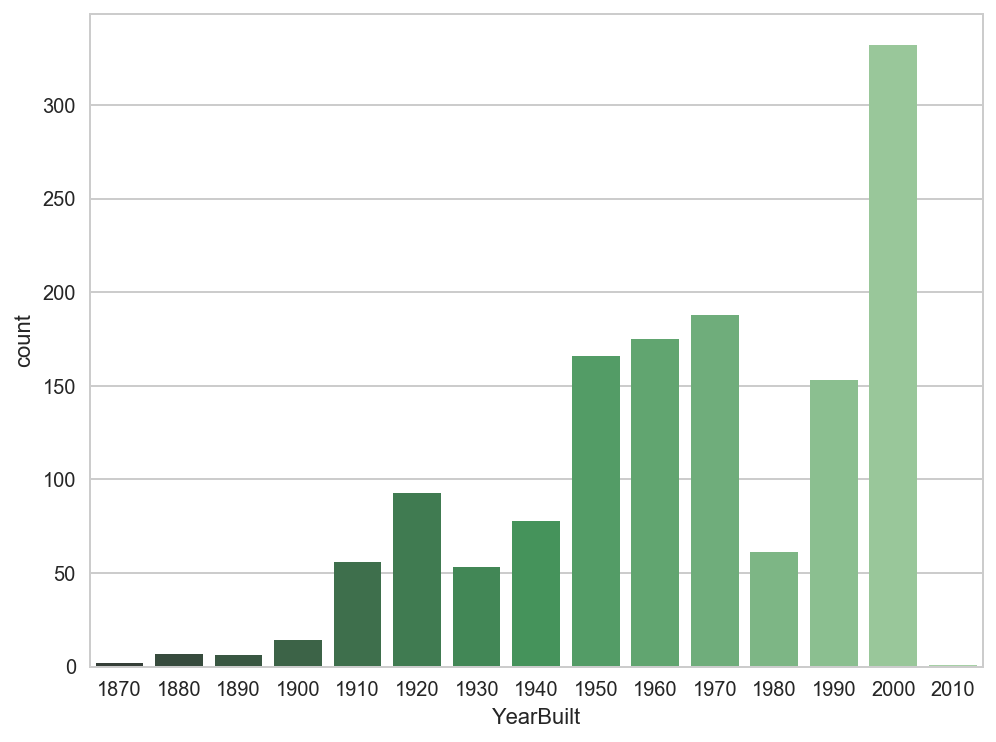

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x="YearBuilt", data=res_houses, palette="Greens_d");

## The Target Variable: Sale Price

Looking at our target variable, Sale Price, we find home values many standard deviations from the mean. In other words: outliers! Our plot shows positive skew in the distribution of sale prices.

In [7]:
res_houses['SalePrice'].describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

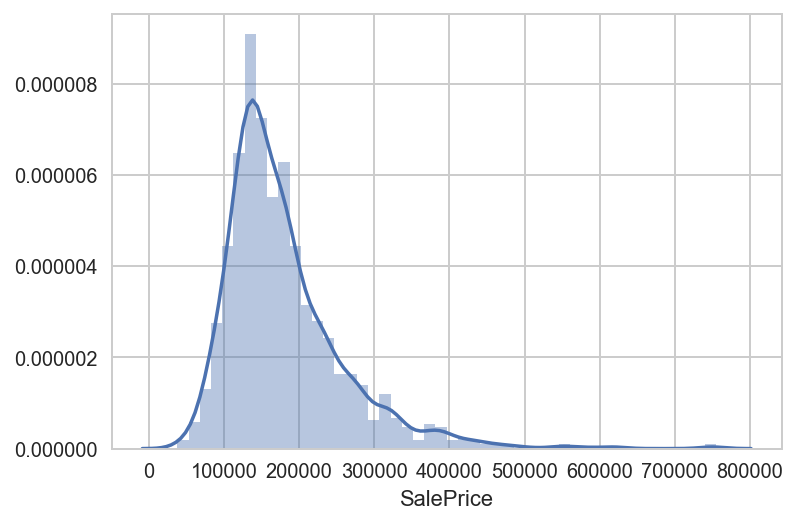

In [8]:
sns.distplot(res_houses['SalePrice']);

Looking at numerical features correlated with sale price (and noting that "numerical" is both a literal and subjective distinction in this dataset^) we see strong relationships to quality features (including overall quality, basment finish, and masonry veneer area) as well as square footage features (including living area, basement square footage, garage area, and porch square feet).


^Like other variables coded as categorical, Overall Quality has relatively few, fixed outcomes, but still more than bedrooms and kitchens, and likewise, we assume with more confidence that as quality increases so too does sale price. (Whereas greater quantity of other features might well offer diminishing or perhaps even negative returns.)

In [9]:
res_houses.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790986
GrLivArea       0.708499
GarageArea      0.629048
TotalBsmtSF     0.617536
1stFlrSF        0.617059
TotRmsAbvGrd    0.536250
MasVnrArea      0.512999
GarageYrBlt     0.486469
BsmtFinSF1      0.394510
Name: SalePrice, dtype: float64

We see here that the slope of the line we could draw between sale price and house quality increases exponentially as house quality increases - there is a much more marginal premium to go from a 4 to a 5 than from an 8 to a 9. We see a similar premium in going from a 2 car garage to a 3 car garage. While it's curious that this trend seems not to extend to 4 car garages, there are too few houses with 4 car garages for us to say it does or doesn't exist with any certainty.

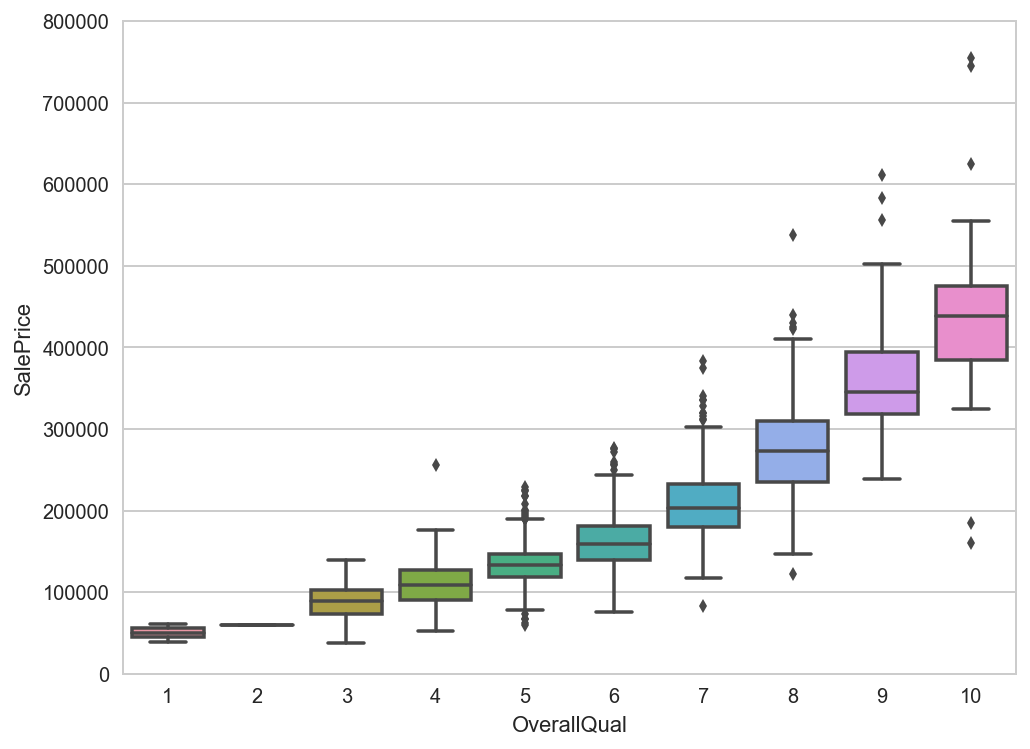

In [10]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=res_houses)
fig.axis(ymin=0, ymax=800000);

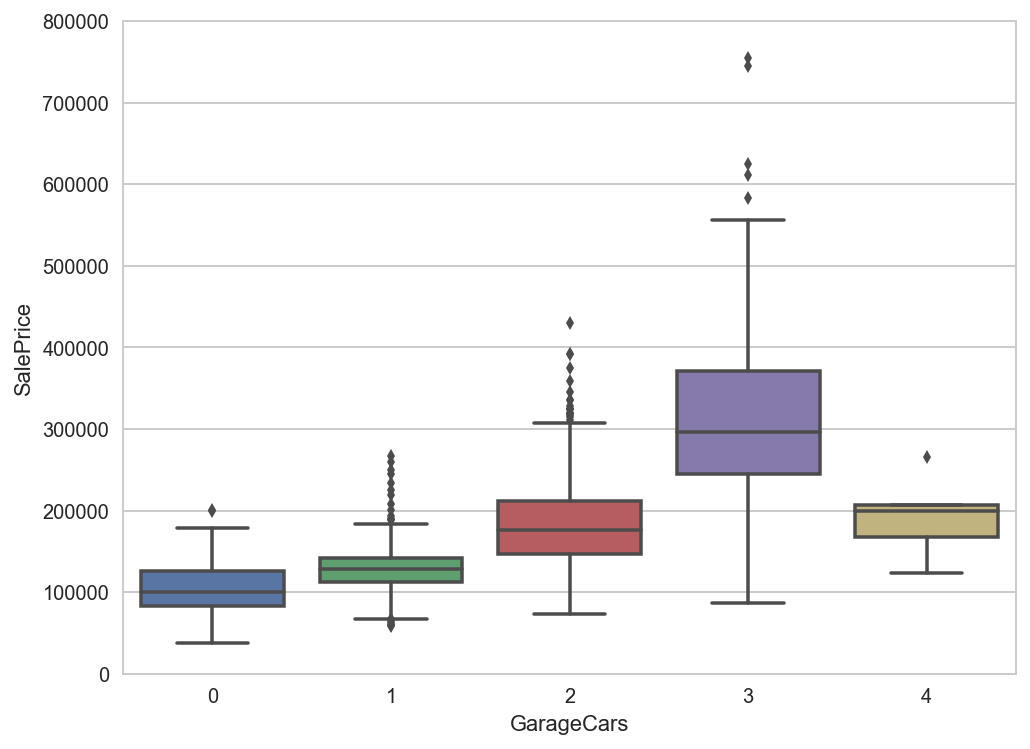

In [11]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x='GarageCars', y="SalePrice", data=res_houses)
fig.axis(ymin=0, ymax=800000);

## Nulls

Our dataset includes a substantail number of features with missing values. For those cases with about 5% of values missing, we can impute the neutral (and in general modal) option where possible - *average quality* basement condition, for example.

We drop those features missing 20% or more values. And that leaves us with myriad features pertaining to garages, for which we have many other proxies for garage value, so we drop those too. With just the one electrical value missing, we'll drop that house.

In [12]:
res_houses.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1378
MiscFeature     1333
Alley           1320
Fence           1108
FireplaceQu      641
LotFrontage      251
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         5
MasVnrType         5
Electrical         1
Utilities          0
dtype: int64

In [13]:
res_houses['BsmtExposure'].fillna('No', inplace=True)
res_houses['BsmtFinType2'].fillna('Unf', inplace=True)
res_houses['BsmtFinType1'].fillna('Unf', inplace=True)
res_houses['BsmtQual'].fillna('TA', inplace=True)
res_houses['BsmtCond'].fillna('TA', inplace=True)
res_houses['MasVnrArea'].fillna(0.0, inplace=True)
res_houses['MasVnrType'].fillna('None', inplace=True)

In [14]:
drop_columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageCond', 'GarageType',
                'GarageYrBlt', 'GarageFinish', 'GarageQual']
res_houses.drop(drop_columns, axis=1, inplace=True)
res_houses.dropna(inplace=True)

## Outliers

Looking at a plot of living area by saleprice, we see both a non-linear relationship between the two variables as well as two distinct outliers at the bottom right of the plot denoting two of the biggest houses in the dataset selling for average sale prices. Something's not right. We'll delete these.

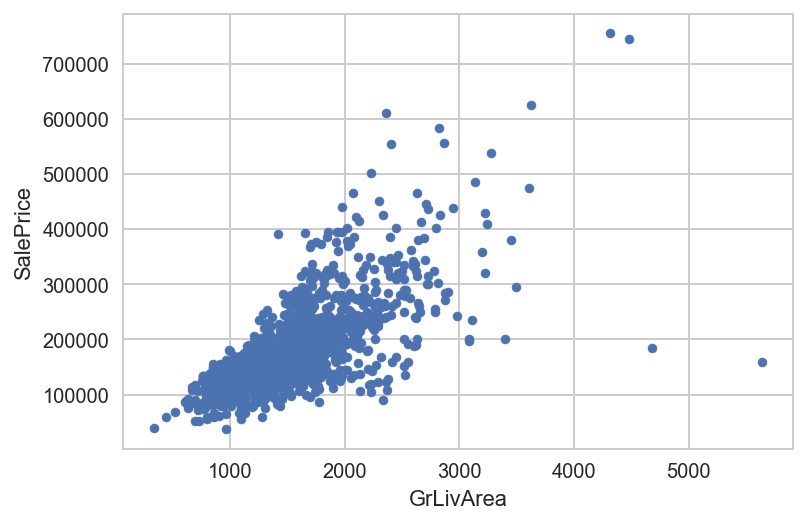

In [15]:
res_houses.plot.scatter(x='GrLivArea', y='SalePrice');

In [16]:
outlier1_mask = (res_houses['GrLivArea'] > 4000) & (res_houses['SalePrice'] < 300000)
res_houses[outlier1_mask]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000


In [17]:
res_houses = res_houses.drop(res_houses[outlier1_mask].index)

# Preprocessing: PCA

PCA fundamentally filters out the multicollinearity between variables, creating new “principal components” that reflect some latent variable. Principal components are also effectively meta-features that pick up distinct clusters of individual features which, once reflected, can then be discarded. PCA is then a "dimensionality reduction" algorithm, collapsing many features into fewer principal components. 

PCA does not take stock of a target variable, the sale price of a home in this case. Each principal component is defined by the strength of each feature’s relationship to the latent variable, as well as the amount of variance in the data that the principal component explains. 

For this analysis, we will isolate the numeric variables in our dataset and then, after standardizing the data, input them into the PCA algorithm.

In [20]:
num_mask = res_houses.dtypes != 'object'
col_list = res_houses.columns[num_mask]
feature_list = []
for e in col_list:
    if (e != 'Id') & (e !='SalePrice'):
        feature_list.append(e)
print(feature_list)
print(len(feature_list))

['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
21


In [21]:
X = res_houses[feature_list]
ss = StandardScaler()
Xn = ss.fit_transform(X)
pca = PCA()
pca.fit(Xn)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
ames_pcs = pca.transform(Xn)
ames_pcs = pd.DataFrame(ames_pcs, 
                       columns=['PC'+str(i+1) for i in range(len(feature_list))], index=res_houses.index)
ames_pcs.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,0.564703,1.084159,0.909520,-1.454549,0.273681,-0.181048,-0.573224,0.228556,-0.473933,-0.033328,...,0.513556,0.134675,0.637739,0.226697,-0.349017,0.393019,0.006680,-0.486276,-1.297112e-16,2.091575e-16
1,-0.321054,-1.449232,1.232153,-0.243270,-0.391239,0.602842,0.587972,-0.317378,0.766829,-0.478466,...,-0.738895,-0.527425,-0.497434,0.762169,0.061489,-0.089216,-0.160625,-0.241420,2.465656e-16,-5.020792e-16
2,0.391394,0.812418,0.222693,-1.117834,0.177273,-0.179460,-0.296578,0.194566,-0.309524,0.114493,...,0.151541,0.125052,0.656009,-0.122135,-0.895817,0.602589,-0.362387,0.515448,-1.970362e-16,-4.411218e-17
3,-0.157160,1.942156,-0.216086,0.564220,-1.780792,0.472925,-1.024534,1.313669,-2.517805,0.409181,...,0.294721,0.321219,-1.039602,-0.917456,-1.361558,0.161133,0.285420,-0.103302,-4.216670e-16,7.191662e-16
4,3.192943,1.232694,0.793420,-1.559556,-0.205333,-0.361275,0.143179,0.056864,-0.098974,0.087783,...,0.234951,-0.133224,0.342938,-0.466524,-0.633501,-0.081958,-0.084402,-0.391166,-1.948880e-16,3.860992e-16


Each principal component explains different amounts of variance and only those that explain more than could be explained by randomly generated data are retained for further analysis. Those principal components that explain little of the variance in the data are discarded. Likewise, all of the original features, reflected in those principal components that are retained, can be discarded as well. We use a method called Horn’s Parallel Analysis to parse which of our 21 principal components (one for each numeric feature in the dataset) explain more variance than random noise, observing that 4 do.

In [23]:
def horn_parallel_analysis(shape, iters=1000, percentile=95):
    pca = PCA(n_components=shape[1])
    eigenvals = []
    
    for i in range(iters):
        rdata = np.random.normal(0,1,size=shape)
        pca.fit(rdata)
        eigenvals.append(pca.explained_variance_)
    
    eigenvals = np.array(eigenvals)
    return np.percentile(eigenvals, percentile, axis=0)

In [24]:
ames_pa = horn_parallel_analysis(Xn.shape, percentile=95)

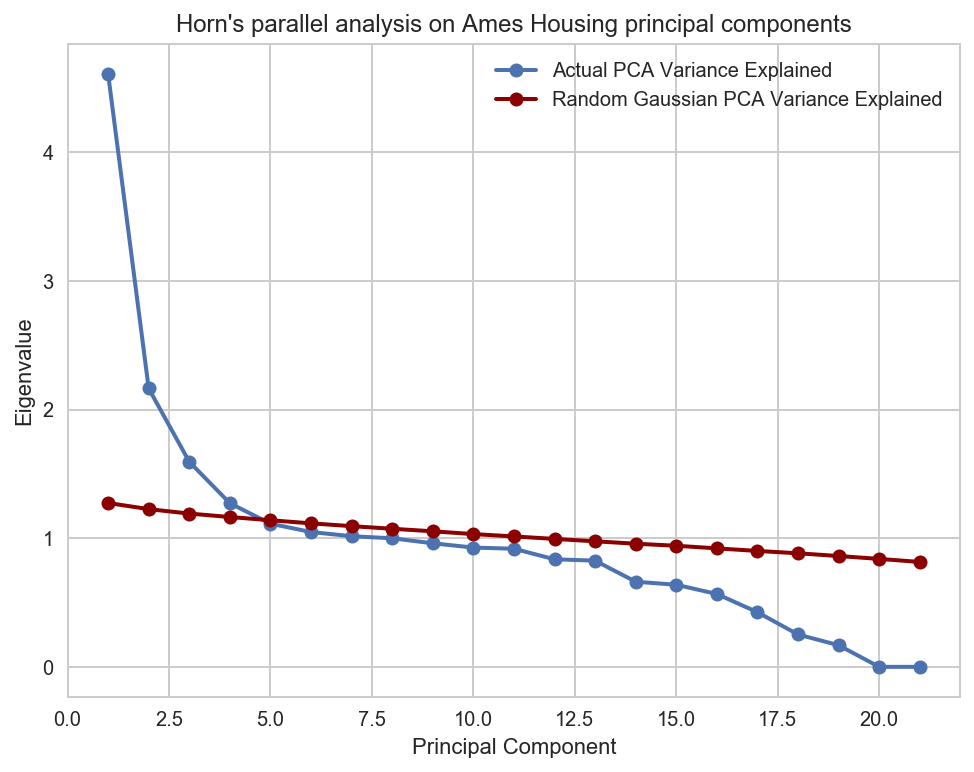

In [25]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, Xn.shape[1]+1), pca.explained_variance_, lw=2, marker='o')
ax.plot(range(1, Xn.shape[1]+1), ames_pa, lw=2, color='darkred', marker='o')

ax.set_title("Horn's parallel analysis on Ames Housing principal components")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Eigenvalue")

plt.legend(['Actual PCA Variance Explained', "Random Gaussian PCA Variance Explained"])
plt.show()

In sum, the 4 strongest principal components explain 46 percent of the variance in our dataset, almost half of that due to the first PC alone. Regarding the first principal component, we see a certain cluster of houses that can be described by high overall quality (note the positive value) and a large amount of space — note the relatively high values for garage area, basement square feet, 1st floor square feet, living area, and total rooms. While space being associated with quality (and implicitly a premium) feels intuitive, the second principal component describes spacious homes as well, but ones that lack finished basements and are perhaps oddly shaped — note how large second floors but below average 1st floor square footages define this group. Reconciling large second floors with small first floors represents a challenge of PCA; without more knowledge of the Ames housing market, it’s hard to explain what is unifying these qualities (the latent variable). But at the same time, our principal components are showing us significant differences between types of spacious houses — some uniformly spacious and high quality, others less consistently spacious and lacking finished basements.

In [26]:
pca.explained_variance_ratio_[:4]

array([ 0.21957274,  0.10307152,  0.07593609,  0.06059235])

In [27]:
pd.DataFrame({'PC1': pca.components_[0], 'PC2': pca.components_[1], 'PC3': pca.components_[2], 
              'PC4':pca.components_[3]}, index=feature_list)

,PC1,PC2,PC3,PC4
LotArea,0.144468,-0.080961,0.218971,0.228148
OverallQual,0.363073,0.019948,-0.064034,-0.103229
OverallCond,-0.091902,0.106377,0.225932,0.135373
MasVnrArea,0.269934,-0.055121,-0.014870,-0.287989
BsmtFinSF1,0.164390,-0.394101,0.430027,-0.199360
BsmtFinSF2,-0.002978,-0.111525,0.228736,0.491101
BsmtUnfSF,0.169570,0.127614,-0.661726,0.190006
TotalBsmtSF,0.349109,-0.318268,-0.163643,0.188057
1stFlrSF,0.357830,-0.266334,-0.108955,0.229497
2ndFlrSF,0.153704,0.560436,0.220963,-0.192951


# Lasso Regression

After using PCA, we turn to our 47 additional categorical features. Getting the dummy variables for these features, and adding the 4 principal components to the predictor values, yields 258 features even after dropping 1 dummy feature from each category. This quantity of variables can be handled by a lasso regression, which specializes in parsing multicollinearity and assigns coefficient values of 0 to features it determines have their predictive value wholly encompassed by other features.

In [28]:
obj_mask = res_houses.dtypes == 'object'
col_list = res_houses.columns[obj_mask]
obj_list = [] #including target vairable in list
for e in col_list:
    obj_list.append(e)
res_houses_dummies = res_houses[obj_list]
res_houses_dummies['SalePrice'] = res_houses['SalePrice']

In [31]:
dummy_list = []
#i=0
for item in obj_list:
    dummy = item + '_' + res_houses_dummies.ix[0,item]
    dummy_list.append(dummy)
print(dummy_list)

['MSSubClass_60', 'MSZoning_RL', 'Street_Pave', 'LotShape_Reg', 'LandContour_Lvl', 'Utilities_AllPub', 'LotConfig_Inside', 'LandSlope_Gtl', 'Neighborhood_CollgCr', 'Condition1_Norm', 'Condition2_Norm', 'BldgType_1Fam', 'HouseStyle_2Story', 'YearBuilt_2000', 'YearRemodAdd_2000', 'RoofStyle_Gable', 'RoofMatl_CompShg', 'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'MasVnrType_BrkFace', 'ExterQual_Gd', 'ExterCond_TA', 'Foundation_PConc', 'BsmtQual_Gd', 'BsmtCond_TA', 'BsmtExposure_No', 'BsmtFinType1_GLQ', 'BsmtFinType2_Unf', 'Heating_GasA', 'HeatingQC_Ex', 'CentralAir_Y', 'Electrical_SBrkr', 'BsmtFullBath_1', 'BsmtHalfBath_0', 'FullBath_2', 'HalfBath_1', 'BedroomAbvGr_3', 'KitchenAbvGr_1', 'KitchenQual_Gd', 'Functional_Typ', 'Fireplaces_0', 'GarageCars_2', 'PavedDrive_Y', 'MoSold_2', 'YrSold_2008', 'SaleType_WD', 'SaleCondition_Normal']


Before running our regression, we drop dummy variables from each category. These dropped dummy variables will be baked into the regression’s intercept. The intercept functions as a baseline value, with value added or debited for the presence of each feature with a coefficient. Lastly, we add our principal components to our dummy variables.

In [32]:
res_houses_dummies = pd.get_dummies(res_houses_dummies)
res_houses_dummies = res_houses_dummies.drop(dummy_list, axis=1)
print(res_houses_dummies.shape)

(1382, 255)


In [33]:
ames_to_res = ames_pcs[['PC1','PC2','PC3','PC4']]
frames = [ames_to_res, res_houses_dummies]
pca_dummies = pd.concat(frames, axis=1)
pca_dummies.head()

,PC1,PC2,PC3,PC4,SalePrice,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,0.564703,1.084159,0.909520,-1.454549,208500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.321054,-1.449232,1.232153,-0.243270,181500,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.391394,0.812418,0.222693,-1.117834,223500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.157160,1.942156,-0.216086,0.564220,140000,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3.192943,1.232694,0.793420,-1.559556,250000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Scoring and Predictions

The lasso regression on the Ames housing dataset yields an r² of .878 in 5-fold cross validation and an r² of .902 for a 20% testing split with regression hyperparameters optimized via Lasso cross-validation.

In [34]:
X = pca_dummies.drop('SalePrice', axis=1)
y = pca_dummies['SalePrice']

Xs = ss.fit_transform(X)

In [35]:
lasso_scores = cross_val_score(Lasso(), Xs, y, cv=5)

print(np.mean(lasso_scores))

0.878126468063


In [38]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

optimal_lasso = LassoCV(n_alphas=1000, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

print('Test score: ', optimal_lasso.score(X_test, y_test))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Test score:  0.913818465012


....................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


We see how sk learn’s prediction method fit on the regression anticipates the sale price of houses in the dataset using test predictors (in other words, without knowing the actual sale prices for those values) below. As one would given our score, the predictions are extremely accurate though notably far off on the most expensive house in the testing split, hinting that we may need another model to handle premium housing stock.

179599.287568


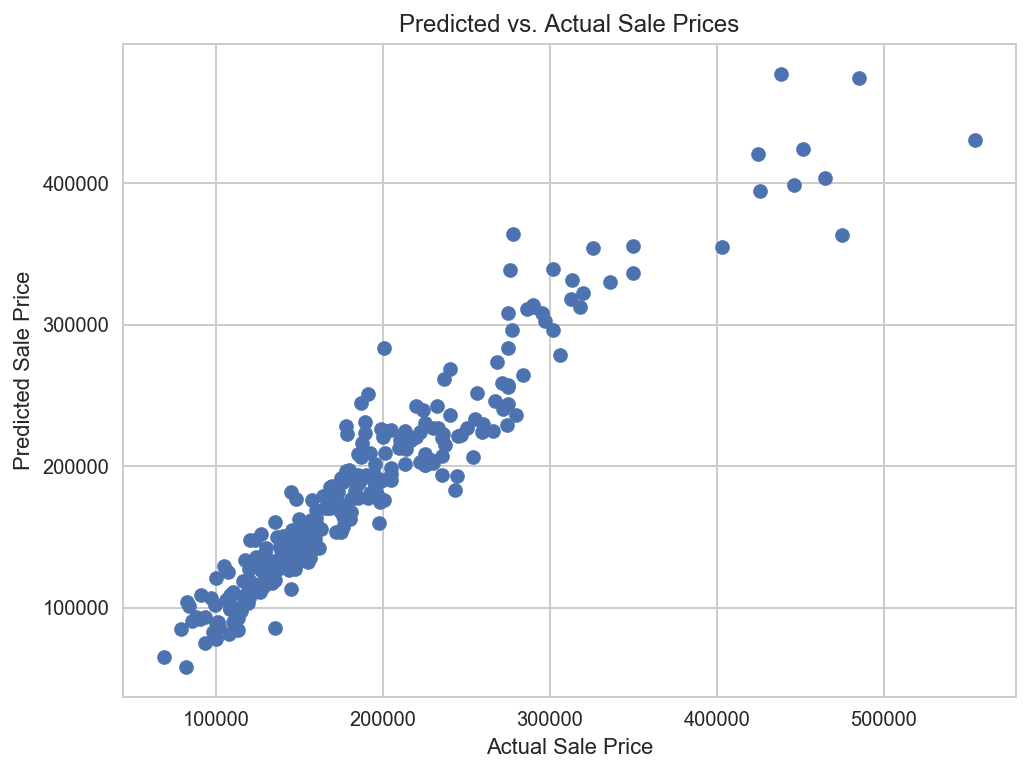

In [40]:
predictions = optimal_lasso.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(y_test, predictions)

ax.set_title("Predicted vs. Actual Sale Prices")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print(optimal_lasso.intercept_)

## Making Sense of Regression Coefficients

We first observe that Lasso has pared our features down by almost 60% - it has done it's job!

In [42]:
print("Lasso used " + str(np.sum(optimal_lasso.coef_ != 0)) + " variables and zeroed out the remaining " + 
        str(np.sum(optimal_lasso.coef_ == 0)) + " variables")

Lasso used 116 variables and zeroed out the remaining 142 variables


Looking at our regression coefficients , we see the first principal component offering far and away the highest premium. This makes sense: the first principal component is a meta-variable encompassing spacious and high quality houses. Other large coefficients include a premium for 3 full bathrooms (relative to the 2 full bathrooms represented in the intercept), excellent kitchen quality, and location in Ames’s North Ridge neighborhood.

There are features we might expect to offer a premium, such as new construction, represented in the intercept. For our most significant negative coefficients, we see average exterior system qualities, old remodels, and medium density zoning. It’s surprising to see two kitchens offer a penalty relative to one, and doubly so for five bedrooms relative to 3 (our dummy case), but they are perhaps proxies for something else (older housing stock?) in this dataset.

In [43]:
lasso_coefs = pd.DataFrame({'coef':optimal_lasso.coef_},index=X.columns)
lasso_coefs.sort_values('coef', inplace=True, ascending=False)

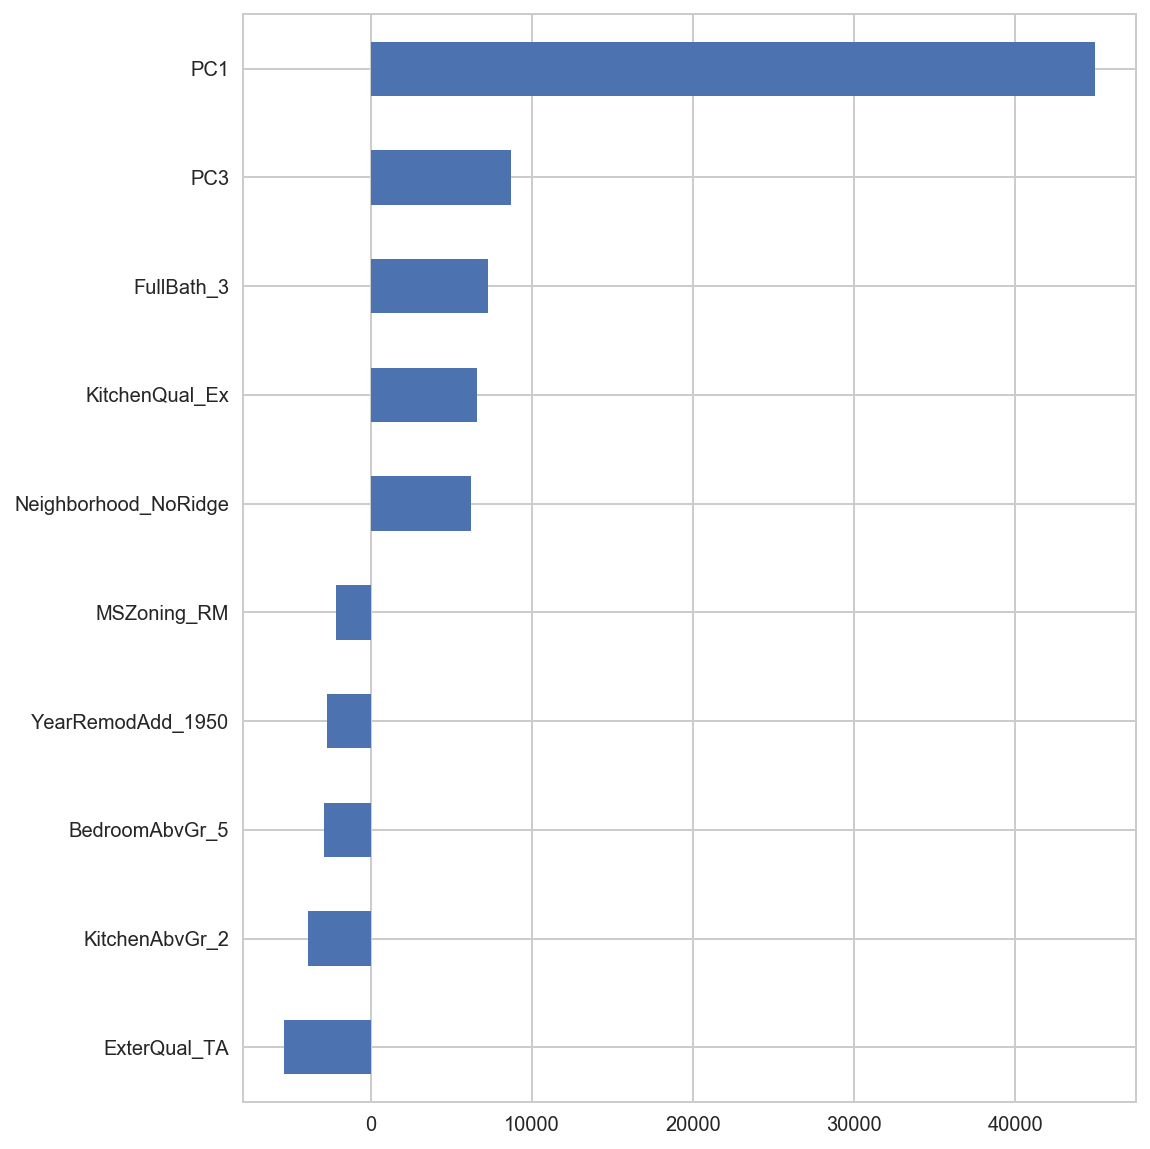

In [44]:
head_tail = pd.concat([lasso_coefs['coef'].sort_values().head(),
                     lasso_coefs['coef'].sort_values().tail()])
head_tail.plot(kind = "barh", figsize=(8,10))
plt.show()

That's all - thank you for reading!